<a href="https://colab.research.google.com/github/Ahmed8aa/Amazon_Project/blob/main/amazon_sc_tr_us.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install selenium
!pip install webdriver_manager
!pip install easyocr
!pip install aiohttp #asyncio
# !pip install nest_asyncio
!pip install azure-storage-blob


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.7/481.7 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.2/307.2 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 912.2/912.2 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 286.8/286.8 kB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 405.6/405.6 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 197.4/197.4 kB 17.0 MB/s eta 0:00:00


In [ ]:
import aiohttp
import asyncio
from urllib.parse import urljoin
import time
import random
import io
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
from tqdm import tqdm
from selenium.common.exceptions import TimeoutException, NoSuchElementException, ElementNotInteractableException, ElementClickInterceptedException
# from google.colab import files
from datetime import datetime
import nest_asyncio
import easyocr
import re

class AmazonScraper:
    def __init__(self, search_term, num_pages, country="Egypt"):
        self.search_term = search_term
        self.num_pages = num_pages
        self.country = country
        self.driver = self.web_driver()
        self.product_data = []
        self.user_agents = [
            'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:91.0) Gecko/20100101 Firefox/91.0',
          'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36',
          'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36 Edg/93.0.961.47',

          # Less common browsers
          'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36 OPR/79.0.4143.50',
          'Mozilla/5.0 (Windows NT 10.0; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/93.0.4577.63 Safari/537.36 Vivaldi/4.1',

          # Older browser versions
          'Mozilla/5.0 (Windows NT 6.1; WOW64; rv:54.0) Gecko/20100101 Firefox/54.0',
          'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_11_6) AppleWebKit/601.7.7 (KHTML, like Gecko) Version/9.1.2 Safari/601.7.7',
        ]
        self.current_user_agent_index = 0
        self.base_url = 'https://www.amazon.com'

    def get_next_user_agent(self):
        user_agent = self.user_agents[self.current_user_agent_index]
        self.current_user_agent_index = (self.current_user_agent_index + 1) % len(self.user_agents)
        return user_agent

    def update_user_agent(self):
        new_user_agent = self.get_next_user_agent()
        self.driver.execute_cdp_cmd('Network.setUserAgentOverride', {"userAgent": new_user_agent})
        print(f"Updated user agent to: {new_user_agent}")

    def web_driver(self):
        options = webdriver.ChromeOptions()
        options.add_argument("--verbose")
        options.add_argument('--no-sandbox')
        options.add_argument('--headless')
        options.add_argument('--disable-gpu')
        options.add_argument("--window-size=1920,1200")
        options.add_argument('--disable-dev-shm-usage')
        driver = webdriver.Chrome(options=options)
        driver.set_window_size(1920, 1080)
        return driver

    def access_amazon(self):
        print("Accessing Amazon...")
        max_attempts = 3
        for attempt in range(max_attempts):
            try:
                self.driver.get('https://www.amazon.com')
                self.handle_captcha()
                return
            except Exception as e:
                print(f"Attempt {attempt + 1} failed: {str(e)}")
                if attempt < max_attempts - 1:
                    print("Retrying...")
                    time.sleep(random.uniform(2, 5))
                else:
                    print("Max attempts reached. Unable to access Amazon.")
                    raise

    def handle_captcha(self):
        try:
            # Check for known keywords that indicate a CAPTCHA is present
            page_source = self.driver.page_source
            captcha_keywords = ["Enter the characters", "اكتب الأحرف", "请键入字符"]  # Add more as needed

            # Check if any of the keywords appear in the page source
            if any(keyword in page_source for keyword in captcha_keywords):
                print("CAPTCHA detected. Taking screenshot...")
                self.take_captcha_screenshot()

                # Wait for the CAPTCHA input field to appear
                captcha_input = WebDriverWait(self.driver, 5).until(
                    EC.presence_of_element_located((By.ID, 'captchacharacters'))
                )

                time.sleep(10)  # Allow time for user to interact or for CAPTCHA to load
                captcha_code = self.extract_captcha_code('after_login.png')

                if captcha_code:
                    print(f"Extracted CAPTCHA code: {captcha_code}")
                    captcha_input.send_keys(captcha_code)
                    continue_button = self.driver.find_element(By.CSS_SELECTOR, 'button.a-button-text')
                    continue_button.click()
                else:
                    print("No CAPTCHA code detected.")
                time.sleep(3)
            else:
                print("No CAPTCHA detected.")
        except TimeoutException:
            print("No CAPTCHA detected.")
        except Exception as e:
            print(f"An error occurred while handling CAPTCHA: {e}")

    def take_captcha_screenshot(self):
        screenshot = self.driver.get_screenshot_as_png()
        image = Image.open(io.BytesIO(screenshot))
        image.save('after_login.png')
        plt.figure(figsize=(12, 8))
        plt.imshow(image)
        plt.axis('off')
        plt.show()

    def extract_captcha_code(self, image_path):
        # Initialize EasyOCR reader
        reader = easyocr.Reader(['en'])
        results = reader.readtext(image_path)
        captcha_text = ' '.join(result[1] for result in results if result[1].isalnum())

        # Simple heuristic: return the first alphanumeric code of appropriate length
        captcha_code = re.findall(r'[A-Z0-9]{6}', captcha_text)
        return captcha_code[0] if captcha_code else None

    def change_amazon_location(self):
        print(f"Attempting to change location to {self.country}")
        max_attempts = 3
        for attempt in range(max_attempts):
            try:
                self.driver.get('https://www.amazon.com')
                time.sleep(5)
                location_button = WebDriverWait(self.driver, 10).until(
                    EC.element_to_be_clickable((By.ID, "glow-ingress-line2"))
                )
                location_button.click()
                time.sleep(2)
                try:
                    deliver_to = WebDriverWait(self.driver, 5).until(
                        EC.element_to_be_clickable((By.ID, "GLUXCountryListDropdown"))
                    )
                    deliver_to.click()
                    time.sleep(2)
                except:
                    print("'Deliver to' dropdown not found, continuing...")
                country_option = WebDriverWait(self.driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, f"//a[contains(text(), '{self.country}')]"))
                )
                country_option.click()
                time.sleep(2)
                done_button = WebDriverWait(self.driver, 10).until(
                    EC.element_to_be_clickable((By.XPATH, "//button[contains(@class, 'a-button-text') and contains(text(), 'Done')]"))
                )
                done_button.click()
                time.sleep(5)
                location_text = WebDriverWait(self.driver, 10).until(
                    EC.presence_of_element_located((By.ID, "glow-ingress-line2"))
                ).text
                if self.country.lower() in location_text.lower():
                    print(f"Successfully changed location to {self.country}")
                    return
                else:
                    print(f"Location change unsuccessful. Current location: {location_text}")
            except Exception as e:
                print(f"Attempt {attempt + 1} to change location failed.")
                if attempt < max_attempts - 1:
                    print("Retrying...")
                    time.sleep(random.uniform(2, 5))
                else:
                    print(f"Failed to change location to {self.country} after {max_attempts} attempts.")
        print("Location change process completed, but may not have been successful.")

    def scroll_with_pauses(self):
        last_height = self.driver.execute_script("return document.body.scrollHeight")
        while True:
            self.driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(random.uniform(1, 2))
            new_height = self.driver.execute_script("return document.body.scrollHeight")
            if new_height == last_height:
                break
            last_height = new_height

    def extract_product_links_and_prices(self):
        print("Extracting product links, prices, ratings, and image URLs...")
        self.driver.get(f"https://www.amazon.com/s?k={self.search_term.replace(' ', '+')}")

        while "Something went wrong" in self.driver.page_source:
            print(f"Error page detected for URL. Navigating to Amazon homepage.")
            self.driver.get('https://www.amazon.com')
            time.sleep(2)
            self.driver.get(f"https://www.amazon.com/?k={self.search_term.replace(' ', '+')}")
            time.sleep(2)

        page_num = 1
        while page_num <= self.num_pages:
            try:
                WebDriverWait(self.driver, 10).until(
                    EC.presence_of_element_located((By.CSS_SELECTOR, "div.s-result-item"))
                )
                self.scroll_with_pauses()
                soup = BeautifulSoup(self.driver.page_source, 'html.parser')
                products = soup.find_all('div', {'data-component-type': 's-search-result'})

                for product in products:
                    try:
                        link_tag = product.find('a', class_='a-link-normal')
                        link = urljoin(self.base_url, link_tag['href']) if link_tag else None

                        price_span = product.select_one('span.a-price-whole')
                        if not price_span:
                            price_span = product.select_one('div[data-cy="secondary-offer-recipe"] span.a-color-base')
                        price = price_span.get_text(strip=True) if price_span else "No Price"
                        list_price_span = product.select_one('span.a-price.a-text-price span.a-offscreen')
                        if not list_price_span:
                            list_price_span = product.select_one('div[data-cy="secondary-offer-recipe"] span.a-color-base')

                        # Extract the text or set a default if not found
                        list_price = list_price_span.get_text(strip=True) if list_price_span else "No List Price"
                        rating_span = product.select_one('span.a-icon-alt')
                        rating = rating_span.get_text(strip=True) if rating_span else "No Rating"

                        img_tag = product.find('img', class_='s-image')
                        image_url = img_tag['src'] if img_tag else "No Image"

                        if link:
                            self.product_data.append({
                                "link": link,
                                "price": price,
                                'price_before_discount':list_price,
                                "currency":'USD',
                                "rating": rating,
                                "image_url": image_url
                            })

                    except Exception as e:
                        print(f"Error processing product: {str(e)}")

                print(f"Extracted {len(self.product_data)} products so far...")

                next_button = self.driver.find_elements(By.CSS_SELECTOR, "a.s-pagination-next")
                if next_button and page_num < self.num_pages:
                    self.driver.execute_script("arguments[0].click();", next_button[0])
                    time.sleep(random.uniform(3, 5))
                    page_num += 1
                else:
                    print(f"Reached the last page or hit the page limit. Stopping at page {page_num}")
                    break

            except Exception as e:
                print(f"Error on page {page_num}: {str(e)}")
                print("Continuing with the data collected so far...")
                break

        print(f"Total products extracted: {len(self.product_data)}")

    async def fetch_page(self, session, url):
        async with session.get(url, timeout=50) as response:
            return await response.text()

    async def extract_product_details_async(self, session, url, extended_sleep=False):
        max_attempts = 3
        for attempt in range(max_attempts):
            try:
                await asyncio.sleep(random.uniform(2, 5) + extended_sleep)
                html = await self.fetch_page(session, url)

                soup = BeautifulSoup(html, 'lxml')

                # Extract product title
                product_title_element = soup.find('span', {'id': 'productTitle'})
                product_title = product_title_element.get_text(strip=True) if product_title_element else 'No title found'

                # Initialize details dictionary
                details = {
                    "Product Title": product_title,
                    "Category": "Mobile Phones",
                    "Site": "Amazon"
                }

                # Extract product details from the table
                table = soup.find('table', class_='a-normal a-spacing-micro')
                if table:
                    rows = table.find_all('tr')
                    for row in rows:
                        key_element = row.find('td', class_='a-span3')
                        value_element = row.find('td', class_='a-span9')

                        if key_element and value_element:
                            key = key_element.get_text(strip=True)
                            value = value_element.get_text(strip=True)
                            details[key] = value
                else:
                    rows = soup.select('#productDetails_detailBullets_sections1 tr')
                    for row in rows:
                        key_element = row.find('th')
                        value_element = row.find('td')

                        if key_element and value_element:
                            key = key_element.get_text(strip=True)
                            value = value_element.get_text(strip=True)
                            details[key] = value

                # Now extract reviews
                all_reviews = []
                if "No customer reviews" in html:
                    print(f"No customer reviews found for URL {url}")
                    reviews_info = {

                        "All Reviews": []
                    }
                else:
                    reviews = soup.find_all('div', {'data-hook': 'review'})
                    for review in reviews:
                        try:
                            reviewer_name = review.find('span', {'class': 'a-profile-name'})
                            rating = review.find('i', {'data-hook': 'review-star-rating'})
                            review_title = review.find('a', {'data-hook': 'review-title'})
                            review_date = review.find('span', {'data-hook': 'review-date'})
                            review_body = review.find('span', {'data-hook': 'review-body'})

                            review_dict = {
                                "Reviewer Name": reviewer_name.text.strip() if reviewer_name else "N/A",
                                "Rating": rating.text.strip() if rating else "N/A",
                                "Title": review_title.find_all('span')[2].text.strip() if review_title and len(review_title.find_all('span')) > 2 else "N/A",
                                "Date": review_date.text.strip() if review_date else "N/A",
                                "Review Body": review_body.text.strip() if review_body else "N/A"
                            }

                            all_reviews.append(review_dict)
                        except Exception as e:
                            print(f"Error extracting review details: {e}")


                    reviews_info = {

                        "All Reviews": all_reviews
                    }

                # Combine product details and reviews
                details.update(reviews_info)

                return details
            except Exception as e:
                print(f"Attempt {attempt + 1} failed for URL {url}.")
                if attempt < max_attempts - 1:
                    print("Retrying...")
                    await asyncio.sleep(random.uniform(2, 5))
                else:
                    print(f"Failed to extract product details for {url} after {max_attempts} attempts.")
                    return {"Product Title": "Error", "Category": "Error"}


    async def run_async_product_details(self):
        try:
            self.access_amazon()
            self.extract_product_links_and_prices()

            async with aiohttp.ClientSession() as session:
                tasks = []
                for idx, product in enumerate(self.product_data, start=1):
                    if idx % 50 == 0:
                        self.update_user_agent()
                    task = asyncio.ensure_future(self.process_product_details(session, product, idx))
                    tasks.append(task)

                self.product_data = await asyncio.gather(*tasks)

            df = pd.DataFrame(self.product_data)

            # Get today's date
            today_date = datetime.now().date()

            # Add a column with today's date
            df['Today'] = today_date

            # print("Saving product details to CSV file...")
            # df.to_csv('amazon_product_details.csv', index=False)
            # print("Product details have been saved successfully.")

        finally:
            pass



    def run_product_details(self):
        asyncio.get_event_loop().run_until_complete(self.run_async_product_details())
        self.driver.quit()

    async def process_product_details(self, session, product, idx):
        extended_sleep = (idx // 250) * 1.5

        details = await self.extract_product_details_async(session, product["link"], extended_sleep)
        product.update(details)

        return product



    async def process_product_reviews(self, session, product_url, idx):
        extended_sleep = (idx // 250) * 1.5

        reviews = await self.extract_reviews_async(session, product_url, extended_sleep)
        return reviews

def main():
    search_term = 'mobile phone'
    num_pages =20
    country = "Egypt"

    nest_asyncio.apply()
    %time


    scraper = AmazonScraper(search_term, num_pages, country)
    scraper.run_product_details()
    return scraper.product_data



CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.34 µs
Accessing Amazon...
CAPTCHA detected. Taking screenshot...


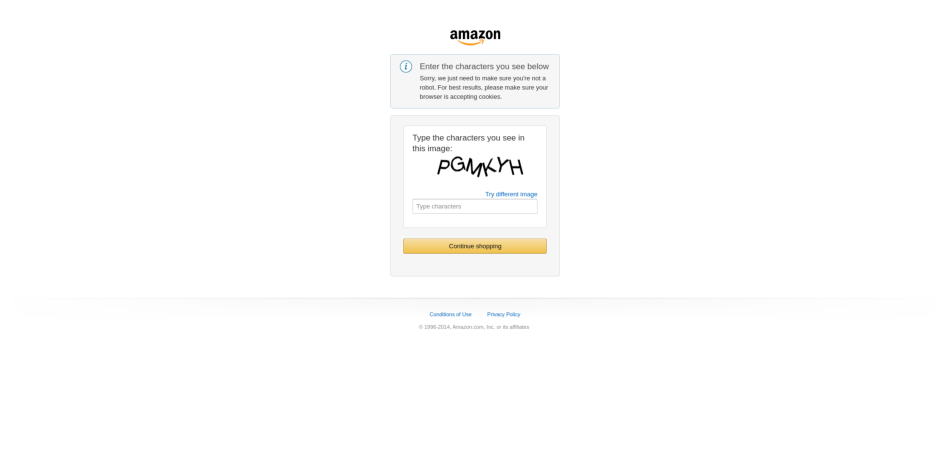

Progress: |██████████████████████████████████████████████████| 100.0% Complete

Progress: |██████████████████████████████████████████████████| 100.0% CompleteExtracted CAPTCHA code: PGMKYH
Extracting product links, prices, ratings, and image URLs...
Extracted 16 products so far...
Extracted 32 products so far...
Extracted 48 products so far...
Extracted 64 products so far...
Extracted 80 products so far...
Extracted 96 products so far...
Extracted 112 products so far...
Extracted 128 products so far...
Extracted 144 products so far...
Extracted 160 products so far...
Extracted 176 products so far...
Extracted 192 products so far...
Extracted 208 products so far...
Extracted 230 products so far...
Extracted 246 products so far...
Extracted 262 products so far...
Extracted 278 products so far...
Extracted 294 products so far...
Extracted 310 products so far...
Extracted 312 products so far...
Reached the last page or hit the page limit. Stopping at page 20
Total products extracted: 312
Updated user agent to: Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:91.0) Gecko/201

In [ ]:
def validate_df(df):
    # Check if df is a list or DataFrame and validate accordingly
    if isinstance(df, list) and df:  # Check if it's a non-empty list
        return True
    elif hasattr(df, 'empty'):  # Check if it's a DataFrame
        return not df.empty
    return False

# Loop until a valid df_f is returned
df_f = None
max_attempts = 5  # Set a limit to avoid infinite loops
attempt = 0

while attempt < max_attempts:
    df_f = main()
    if validate_df(df_f):
        print("DataFrame successfully processed.")
        break
    else:
        print(f"Attempt {attempt + 1}: DataFrame is not valid. Reprocessing...")
        attempt += 1

if df_f is None or not validate_df(df_f):
    print("Failed to generate a valid DataFrame after multiple attempts.")
else:
    print("Final DataFrame")

In [ ]:
df=pd.DataFrame(df_f)

In [ ]:
# Get today's date
today_date = datetime.now().date()

# Add a column with today's date
df['date'] = today_date

In [ ]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
import os

# Azure Storage connection string
connect_str = "DefaultEndpointsProtocol=https;AccountName=ynwa;AccountKey=aTLtGZuymmaAirlsL1/39g3dDjaQvBFu3lHzQaUrY0o6LDdGduAW8Wbk8qI7fuilCKS8chuiklq7+AStBN3UdA==;EndpointSuffix=core.windows.net"

# Initialize BlobServiceClient
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

# Name of the container and blob
container_name = "disco"  # Replace with your container name
folder_name = "raw"

# Name of the blob (file) with today's date
blob_name = f"{folder_name}/amazon_us_raw{today_date}.csv"  # Example: scraped_data_2024-10-07.csv

# Create a container if it doesn't exist
container_client = blob_service_client.get_container_client(container_name)
try:
    container_client.create_container()
except Exception as e:
    print(f"Container already exists: {e}")


# Save the CSV locally (you can skip this if you already have the file path)
csv_file_path = f"scraped_data_{today_date}.csv"
df.to_csv(csv_file_path, index=False)

# Upload the CSV file to Blob Storage with today's date in the name
with open(csv_file_path, "rb") as data:
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)
    blob_client.upload_blob(data, overwrite=True)
    print(f"CSV file {blob_name} uploaded successfully.")


Container already exists: The specified container already exists.
RequestId:9e7d143f-801e-0049-7170-22bb72000000
Time:2024-10-19T21:50:27.2292104Z
ErrorCode:ContainerAlreadyExists
Content: <?xml version="1.0" encoding="utf-8"?><Error><Code>ContainerAlreadyExists</Code><Message>The specified container already exists.
RequestId:9e7d143f-801e-0049-7170-22bb72000000
Time:2024-10-19T21:50:27.2292104Z</Message></Error>
CSV file raw/amazon_us_raw2024-10-19.csv uploaded successfully.


### Transformation

In [ ]:
df_new=df.copy()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 312 entries, 0 to 311
Data columns (total 53 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   link                         312 non-null    object
 1   price                        312 non-null    object
 2   price_before_discount        312 non-null    object
 3   currency                     312 non-null    object
 4   rating                       312 non-null    object
 5   image_url                    312 non-null    object
 6   Product Title                312 non-null    object
 7   Category                     312 non-null    object
 8   Site                         312 non-null    object
 9   Brand                        301 non-null    object
 10  Operating System             280 non-null    object
 11  Ram Memory Installed Size    245 non-null    object
 12  CPU Speed                    134 non-null    object
 13  Memory Storage Capacity      293 no

In [ ]:
ordered_columns_original = [ 'link','Site','Category','rating', 'image_url',
    'Brand', 'Model Name', 'Product Title', 'price','currency',
    'Operating System', 'Ram Memory Installed Size',
    'Memory Storage Capacity', 'Screen Size', 'Resolution', 'Refresh Rate',
    'CPU Speed', 'Connectivity Technology', 'CPU Model', 'Color','price_before_discount',
    'Wireless Carrier', 'Cellular Technology','date',
     'All Reviews'
]
# Ensure all desired columns are present in the DataFrame
missing_columns = set(ordered_columns_original) - set(df_new.columns)
if missing_columns:
    print(f"Warning: Missing columns: {missing_columns}")

df_new = df_new[ordered_columns_original]
df_new['Site']='amazon_us'


<ipython-input-59-b1acf40227f9>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['Site']='amazon_us'


In [ ]:
import re
# Function to clean and convert the price to an integer
def clean_price(price_str):
    # Check if the input is a valid string
    if not isinstance(price_str, str) or not price_str.strip():
        return None  # Return None if it's not a valid string

    # Remove any non-numeric characters except for the decimal point and commas
    cleaned_price = re.sub(r'[^\d.,]', '', price_str)

    # Replace commas with nothing to clean thousands separator
    cleaned_price = cleaned_price.replace(',', '')

    # If the cleaned price is empty or just a period, return None
    if not cleaned_price or cleaned_price == '.':
        return None

    # Convert the cleaned price to a float first and then cast it to an integer
    price_value = float(cleaned_price)  # Convert to float to handle decimal if any
    return int(price_value)  # Cast to integer, truncating any decimals

# Apply the cleaning function to the 'price_before_discount' column
df_new['price'] = df_new['price'].apply(clean_price)

<ipython-input-60-4967fe4fdfff>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['price'] = df_new['price'].apply(clean_price)


In [ ]:
# Function to clean and convert the price to an integer
def clean_price(price_str):
    # Check if the input is a valid string
    if not isinstance(price_str, str) or not price_str.strip():
        return None  # Return None if it's not a valid string

    # Remove any non-numeric characters except the decimal point
    cleaned_price = re.sub(r'[^\d.]', '', price_str)

    # If cleaned_price is empty, return None
    if not cleaned_price:
        return None

    # Convert the cleaned price to a float first and then cast it to an integer
    price_value = float(cleaned_price)  # Convert to float first to handle decimals
    return int(price_value)  # Cast to integer (truncates the decimal part)

# Apply the cleaning function to the 'price_before_discount' column
df_new['price_before_discount'] = df_new['price_before_discount'].apply(clean_price)

<ipython-input-61-bf6960224241>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_new['price_before_discount'] = df_new['price_before_discount'].apply(clean_price)


In [ ]:
# Create a copy of df_new if it is a slice
df_new = df_new.copy()

# Drop rows with NaN values in the specified subset
df_new.dropna(subset=['Model Name', 'price'], inplace=True)
df_new.dropna(subset=['Model Name','price'],inplace=True)

In [ ]:
# Set 'price' to None where 'discount' is less than 0
df_new.loc[df_new['price'] > df_new['price_before_discount'], 'price_before_discount'] = None

In [ ]:
# pd.reset_option('display.max_colwidth', None)

In [ ]:
df_new.info()

<class 'pandas.core.frame.DataFrame'>
Index: 285 entries, 1 to 311
Data columns (total 25 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   link                       285 non-null    object 
 1   Site                       285 non-null    object 
 2   Category                   285 non-null    object 
 3   rating                     285 non-null    object 
 4   image_url                  285 non-null    object 
 5   Brand                      285 non-null    object 
 6   Model Name                 285 non-null    object 
 7   Product Title              285 non-null    object 
 8   price                      285 non-null    float64
 9   currency                   285 non-null    object 
 10  Operating System           271 non-null    object 
 11  Ram Memory Installed Size  239 non-null    object 
 12  Memory Storage Capacity    285 non-null    object 
 13  Screen Size                272 non-null    object 
 14 

In [ ]:
df_new['discount']=((df_new['price_before_discount']-df_new['price'])/df_new['price_before_discount'])*100

In [ ]:
# Convert 'price' column from float to int, handling None/NaN values
df_new['price'] = df_new['price'].astype(int)
df_new['price_before_discount'] = df_new['price_before_discount'].fillna(df_new['price'])
# Convert 'price_before_discount' column from float to int, handling None/NaN values
df_new['price_before_discount'] = df_new['price_before_discount'].astype(int)

In [ ]:
def format_column_names(column_names):
    return [name.replace(' ', '_').lower() for name in column_names]

# Preprocess column names in the DataFrame
df_new.columns = format_column_names(df_new.columns)

In [ ]:
df_new.rename(columns={'operating_system':'os','ram_memory_installed_size':'ram',
                         'memory_storage_capacity':'storage','today':'date'}, inplace=True)

In [ ]:
#drop nulls in model name
df_new.dropna(subset=['model_name','price'], inplace=True)
df_new.reset_index(drop=True, inplace=True)
df_new.shape

(285, 26)

In [ ]:
# Convert all values to lowercase

df_new = df_new.apply(lambda x: x.apply(lambda y: y.lower() if isinstance(y, str) else y) if x.name not in ['link', 'image_url'] else x)

In [ ]:
df_last=df_new.copy()

In [ ]:
# Function definitions with updated names
def format_samsung_model(model):
    model = model.lower()  # Convert to lowercase for consistency

    # Extract special terms like FE, Ultra, Plus, 5G, 4G
    special_terms = re.findall(r'\b(fe|ultra|plus)\b', model, re.IGNORECASE)
    special_terms = list(dict.fromkeys(special_terms))  # Remove duplicates while maintaining order
    special_terms_str = ' '.join(special_terms).upper()

    # Remove unwanted words and characters
    model = re.sub(r'\b(samsung|galaxy)\b', '', model).strip()
    model = re.sub(r'\b(5g|4g)\b', '', model).strip()  # Remove 5G/4G here to prevent duplication

    # Extract core model name
    if 'note' in model:
        match = re.search(r'note\s*(\d*)\s*(\w*)', model)
        if match:
            note_num, note_suffix = match.groups()
            core_model = f"Note {note_num} {note_suffix}".strip().title()
    else:
        match = re.search(r'([a-z]+\s*\d+(?:\s*[a-z]+)?)', model)
        if match:
            core_model = match.group(1).strip().title()
        else:
            core_model = model.strip().title()

    # Remove special terms from core_model if they're already present
    for term in special_terms:
        core_model = re.sub(rf'\b{term}\b', '', core_model, flags=re.IGNORECASE).strip()

    # Combine core model and special terms
    result = f'{core_model} {special_terms_str}'.strip()

    return result.lower()

def clean_motorola_model(model):
    if not isinstance(model, str):
        return model

    # Remove "moto" and "motorola"
    model = re.sub(r'\bmoto\b|\bmotorola\b', '', model)

    # Remove '+' characters
    model = re.sub(r'\+', '', model)

    # Remove parentheses but preserve the content
    model = re.sub(r'\s*\((\d{4})\)', r' \1', model)  # Preserve year in parentheses

    # Remove single quotes in years (e.g., '22)
    model = re.sub(r'\'(\d{2})', r'\1', model)

    # Replace multiple spaces with a single space
    model = re.sub(r'\s+', ' ', model)

    # Strip leading and trailing whitespace
    model = model.strip()

    return model
def extract_google_model(model):
    # Ensure model is a string
    if not isinstance(model, str):
        return model  # Return the original value if it's not a string

    # Convert to lowercase for consistency
    model = model.lower()

    # Use regex to extract everything after "pixel"
    match = re.search(r'\bpixel\s+(.*)', model)
    if match:
        return match.group(1).strip()  # Return the portion after "pixel"

    return model

def clean_oneplus_model(model):
    if not isinstance(model, str):
        return model

    # Remove "oneplus" and leading whitespace
    model = re.sub(r'\boneplus\b', '', model).strip()

    # Remove parentheses but keep the content inside
    model = re.sub(r'\s*\(', ' ', model)
    model = re.sub(r'\)', '', model)

    # Remove any text associated with "gb"
    model = re.sub(r'\s*\d+gb\b', '', model, flags=re.IGNORECASE).strip()

    # Extract text up to and including "5g"
    match = re.search(r'(.*?\b5g\b)', model)
    if match:
        model = match.group(1).strip()

    return model

def remove_xiaomi_brand(model):
    return model.replace('xiaomi', '').strip()

def extract_iphone_model(model):
    parts = model.split('iphone ', 1)
    if len(parts) > 1:
        return parts[1].split('\t', 1)[0].strip()
    return model.strip()

# Function to apply based on brand
def process_model(row):
    brand = row['brand'].lower()
    model_name = row['model_name']

    if brand == 'samsung':
        return format_samsung_model(model_name)
    elif brand == 'motorola':
        return clean_motorola_model(model_name)
    elif brand == 'google':
        return extract_google_model(model_name)
    elif brand == 'oneplus':
        return clean_oneplus_model(model_name)
    elif brand == 'xiaomi':
        return remove_xiaomi_brand(model_name)
    elif brand == 'apple':
        return extract_iphone_model(model_name)
    else:
        return model_name


# Apply function to the DataFrame
df_last['model_name'] = df_last.apply(process_model, axis=1)

In [ ]:

# Define the function to extract and format OS versions
def extract_versions(text):
    if not isinstance(text, str):  # Ensure the input is a string
        return ''

    text = text.lower()  # Convert to lowercase for consistency

    results = set()  # Use a set to avoid duplicates

    # Helper function to format version numbers
    def format_version(version):
        if '.' not in version:
            return f"{version}.0"  # Add '.0' if there is no decimal point
        return version

    # Special case for 'google_android'
    if 'google_android' in text:
        text = 'android' + text.split('google_android')[1]

    # Extract Android version numbers
    android_match = re.search(r'\bandroid\s+(\d+(\.\d+)?)\b', text)
    if android_match:
        version = format_version(android_match.group(1))
        results.add(f"android {version}")

    # Extract iOS version numbers
    ios_match = re.search(r'\bios\s+(\d+(\.\d+)?)\b', text)
    if ios_match:
        version = format_version(ios_match.group(1))
        results.add(f"ios {version}")

    # Extract any other OS version numbers
    os_match = re.search(r'\b(\w+os)\s+(\d+(\.\d+)?)\b', text)
    if os_match:
        os_name = os_match.group(1).lower()
        version = format_version(os_match.group(2))
        results.add(f"{os_name} {version}")

    # Return the results as a comma-separated string
    return ', '.join(results) if results else text
df_last['os'] = df_last['os'].apply(extract_versions)

In [ ]:
df_last['os']=df_last.os.map(lambda x: 'android' if 'oxygenos' in x else x)


In [ ]:
# Define the function to extract RAM size
def extract_ram(text):
    if not isinstance(text, str):  # Ensure the input is a string
        return ''

    # Use regex to find the RAM size
    match = re.search(r'(\d+)\s*gb', text, re.IGNORECASE)
    if match:
        return match.group(1)  # Return only the numeric part of the RAM size

    return ''  # Return empty string if no match is found
df_last['ram']=df_last['ram'].apply(extract_ram)

In [ ]:
# Function to extract storage size
def extract_storage(text):
    if not isinstance(text, str):  # Ensure the input is a string
        return ''

    match = re.search(r'(\d+)\s*gb', text, re.IGNORECASE)
    if match:
        return match.group(1)  # Return only the numeric part of the storage size

    return ''  # Return empty string if no match is found

# Function to extract screen size
def extract_screen_size(text):
    if not isinstance(text, str):  # Ensure the input is a string
        return ''

    match = re.search(r'(\d+(\.\d+)?)\s*inches?', text, re.IGNORECASE)
    if match:
        return match.group(1)  # Return the screen size

    return ''  # Return empty string if no match is found

# Function to extract resolution
def extract_resolution(text):
    if not isinstance(text, str):  # Ensure the input is a string
        return ''

    # Use regex to find resolution in formats like '1920 x 1080', '1920x1080', '1280 x 720 pixels', etc.
    match = re.search(r'(\d{3,4})\s*x\s*(\d{3,4})\b', text, re.IGNORECASE)
    if match:
        return f"{match.group(1)} x {match.group(2)}"  # Return resolution in 'width x height' format

    # Handle cases where resolution might be written as '1920x1080' without spaces
    match_no_space = re.search(r'(\d{3,4})\s*x\s*(\d{3,4})', text, re.IGNORECASE)
    if match_no_space:
        return f"{match_no_space.group(1)} x {match_no_space.group(2)}"  # Return resolution in 'width x height' format

    return ''  # Return empty string if no match is found

# Function to extract refresh rate
def extract_refresh_rate(text):
    if not isinstance(text, str):  # Ensure the input is a string
        return ''

    match = re.search(r'(\d+)\s*hz', text, re.IGNORECASE)
    if match:
        return match.group(1)  # Return the refresh rate

    return ''  # Return empty string if no match is found

# Function to extract CPU speed
def extract_cpu_speed(text):
    if not isinstance(text, str):  # Ensure the input is a string
        return ''

    match = re.search(r'(\d+(\.\d+)?)\s*ghz', text, re.IGNORECASE)
    if match:
        return match.group(1)  # Return the CPU speed

    return ''  # Return empty string if no match is found


In [ ]:
df_last['storage']=df_last['storage'].apply(extract_storage)
df_last['screen_size']=df_last['screen_size'].apply(extract_screen_size)
df_last['resolution']=df_last['resolution'].apply(extract_resolution)
df_last['refresh_rate']=df_last['refresh_rate'].apply(extract_refresh_rate)
df_last['cpu_speed']=df_last['cpu_speed'].apply(extract_cpu_speed)


In [ ]:
df_last.rename(columns={'ram':'ram_gb','screen_size':'screen_size_in','refresh_rate':'refresh_rate_hz','cpu_speed':'cpu_speed_ghz'},inplace=True)

In [ ]:
df_last['wireless_carrier']=df_last['wireless_carrier'].map(lambda x: 'unlocked' if x=='unlocked for all carriers' or x==' unlocked' else x)

In [ ]:
# Define the mapping dictionary
carrier_mapping = {
    'unlocked': 'unlocked',
    'tracfone': 'tracfone',
    'verizon': 'verizon',
    'verizon wireless': 'verizon',
    't-mobile': 't-mobile',
    'simple mobile': 'simple mobile',
    '3': '3',
    'mvno': 'mvno',
    't-mobile, at&t': 't-mobile',
    'at&t': 'at&t',
    'straight talk': 'straight talk',
    'boost mobile': 'boost mobile',
    'vodafone': 'vodafone',
    't-mobile, unlocked': 't-mobile',
    't-mobile, unlocked, verizon, sprint': 't-mobile',
    't-mobile, unlocked, sprint': 't-mobile',
    'sprint': 'sprint',
    'total wireless': 'total wireless'
}

# Handle NaN values separately
df_last['wireless_carrier'] = df_last['wireless_carrier'].fillna('')

# Apply the mapping dictionary
df_last['wireless_carrier'] = df_last['wireless_carrier'].map(carrier_mapping).fillna(df_last['wireless_carrier'])

In [ ]:
import numpy as np
# Replace all zeroes with NaNs
df_last.replace(0, np.nan, inplace=True)

In [ ]:
# Replace empty strings and spaces with NaNs
df_last.replace(r'^\s*$', np.nan, regex=True, inplace=True)

In [ ]:
# Convert `price_usd` to numeric
df_last['price'] = pd.to_numeric(df_last['price'], errors='coerce')

# Convert `ram_gb`, `storage`, `screen_size_in`, `refresh_rate_hz`, `cpu_speed_ghz` to numeric
df_last['ram_gb'] = pd.to_numeric(df_last['ram_gb'], errors='coerce')
df_last['storage'] = pd.to_numeric(df_last['storage'], errors='coerce')
df_last['screen_size_in'] = pd.to_numeric(df_last['screen_size_in'], errors='coerce')
df_last['refresh_rate_hz'] = pd.to_numeric(df_last['refresh_rate_hz'], errors='coerce')
df_last['cpu_speed_ghz'] = pd.to_numeric(df_last['cpu_speed_ghz'], errors='coerce')

In [ ]:
def extract_product_id(url):
    # Regular expression pattern to capture product ID after '/dp/'
    pattern = r'/dp/([A-Za-z0-9]+)'
    match = re.search(pattern, url)

    if match:
        return match.group(1)
    else:
        return None

def get_review_url( product_url):
        asin =extract_product_id(product_url)
        if asin:
            return f"https://www.amazon.com/product-reviews/{asin}"
        return None
def extract_rating(text):
    # Regular expression to match a floating point number at the start of the string
    pattern = r'(\d+\.\d+)'
    match = re.search(pattern, text)

    if match:
        return float(match.group(1))
    else:
        return None

In [ ]:
df_last['ASIN']=df_last['link'].apply(extract_product_id)
df_last['review_url']=df_last['link'].apply(get_review_url)
df_last['rating']=df_last['rating'].apply(extract_rating)

In [ ]:
df=df_last.copy()
# Function to extract and remove network type
def extract_network(text):
    # Check if text is a string, otherwise return it unchanged
    if isinstance(text, str):
        match = re.search(r'(5g|4g)', text)
        if match:
            network = match.group(0)
            # Remove 5G/4G from the original text
            text = re.sub(r'\s?(5g|4g)\s?', '', text).strip()
            return text, network
    return text, None

# Initialize 'network' column as None
df['network'] = None

# Apply the extraction logic to each column and update 'network' column
for col in ['model_name', 'product_title', 'cellular_technology']:
    # Apply the function to extract network and updated column text
    df[col], extracted_networks = zip(*df[col].apply(extract_network))

    # Fill the 'network' column where it is None with the extracted network
    df['network'] = df['network'].combine_first(pd.Series(extracted_networks))


In [ ]:
# Fill any remaining None values in 'network' using 'cellular_technology'
df['network'] = df['network'].fillna(df['cellular_technology'])

In [ ]:
df.drop(columns=['cellular_technology'],inplace=True)
df.dropna(subset=['price'],inplace=True)

In [ ]:
df.date=df.date.astype('datetime64[ns]')

In [ ]:
from azure.storage.blob import BlobServiceClient, BlobClient, ContainerClient
import os

# Azure Storage connection string
connect_str = "DefaultEndpointsProtocol=https;AccountName=ynwa;AccountKey=aTLtGZuymmaAirlsL1/39g3dDjaQvBFu3lHzQaUrY0o6LDdGduAW8Wbk8qI7fuilCKS8chuiklq7+AStBN3UdA==;EndpointSuffix=core.windows.net"

# Initialize BlobServiceClient
blob_service_client = BlobServiceClient.from_connection_string(connect_str)

# Name of the container and blob
container_name = "disco"  # Replace with your container name
folder_name = "transformed"

# Name of the blob (file) with today's date
blob_name = f"{folder_name}/amazon_us_tr{today_date}.csv"  # Example: scraped_data_2024-10-07.csv

# Create a container if it doesn't exist
container_client = blob_service_client.get_container_client(container_name)
try:
    container_client.create_container()
except Exception as e:
    print(f"Container already exists: {e}")


# Save the CSV locally (you can skip this if you already have the file path)
csv_file_path = f"scraped_data_{today_date}.csv"
df.to_csv(csv_file_path, index=False)

# Upload the CSV file to Blob Storage with today's date in the name
with open(csv_file_path, "rb") as data:
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob_name)
    blob_client.upload_blob(data, overwrite=True)
    print(f"CSV file {blob_name} uploaded successfully.")


Container already exists: The specified container already exists.
RequestId:b1714863-d01e-006b-6770-227e6d000000
Time:2024-10-19T21:50:29.9079864Z
ErrorCode:ContainerAlreadyExists
Content: <?xml version="1.0" encoding="utf-8"?><Error><Code>ContainerAlreadyExists</Code><Message>The specified container already exists.
RequestId:b1714863-d01e-006b-6770-227e6d000000
Time:2024-10-19T21:50:29.9079864Z</Message></Error>
CSV file transformed/amazon_us_tr2024-10-19.csv uploaded successfully.


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from azure.storage.blob import BlobServiceClient
import pyarrow as pa
import pyarrow.parquet as pq
import io
import json
import hashlib

def generate_unique_product_id(row):
    unique_string = f"{row['brand']}_{row['model_name']}_{row['storage']}_{row['ram_gb']}_{row['network']}"
    return hashlib.md5(unique_string.encode()).hexdigest()

def assign_partition(row, id_column, num_partitions=7):
    return int(hashlib.md5(str(row[id_column]).encode()).hexdigest(), 16) % num_partitions

def read_parquet_from_blob(blob_service_client, container_name, folder_name, file_name):
    blob_client = blob_service_client.get_blob_client(container=container_name, blob=f"{folder_name}/{file_name}")
    stream = blob_client.download_blob()
    bytes_data = stream.readall()
    return pd.read_parquet(io.BytesIO(bytes_data))

def read_partitioned_parquet_from_blob(blob_service_client, container_name, folder_name, file_name):
    all_data = []
    for i in range(7):  # Assuming 7 partitions
        try:
            blob_client = blob_service_client.get_blob_client(container=container_name, blob=f"{folder_name}/{file_name}/{i}_{file_name}")
            stream = blob_client.download_blob()
            bytes_data = stream.readall()
            partition_data = pd.read_parquet(io.BytesIO(bytes_data))
            all_data.append(partition_data)
        except Exception as e:
            print(f"Error reading partition {i}: {e}")
    return pd.concat(all_data, ignore_index=True) if all_data else pd.DataFrame()

def write_to_parquet(data, blob_service_client, container_name, folder_name, file_name, partition_strategy=None):
    if partition_strategy is None:
        table = pa.Table.from_pandas(data)
        buf = io.BytesIO()
        pq.write_table(table, buf)
        buf.seek(0)

        blob_client = blob_service_client.get_blob_client(container=container_name, blob=f"{folder_name}/{file_name}")
        blob_client.upload_blob(buf.getvalue(), overwrite=True)
    else:
        data['partition'] = data.apply(partition_strategy, axis=1)
        for partition, partition_data in data.groupby('partition'):
            partition_data = partition_data.drop('partition', axis=1)
            table = pa.Table.from_pandas(partition_data)
            buf = io.BytesIO()
            pq.write_table(table, buf)
            buf.seek(0)

            blob_client = blob_service_client.get_blob_client(container=container_name,
                                                              blob=f"{folder_name}/{file_name}/{partition}_{file_name}")
            blob_client.upload_blob(buf.getvalue(), overwrite=True)

def update_fact_table(existing_fact, new_data):
    new_fact = process_fact_table(new_data)
    updated_fact = pd.concat([existing_fact, new_fact]).drop_duplicates(subset=['product_id','site_id','date','url'], keep='last')
    return updated_fact

def update_dim_device_specification(existing_dim, new_data):
    new_dim = process_dim_device_specification(new_data)
    updated_dim = pd.concat([existing_dim, new_dim]).drop_duplicates(subset=['product_id'], keep='last')
    return updated_dim

def update_product_mapping(existing_mapping, new_data):
    new_mapping = process_product_mapping(new_data)
    updated_mapping = pd.concat([existing_mapping, new_mapping]).drop_duplicates(subset=['product_id'], keep='last')
    return updated_mapping

def update_dim_site(existing_site, new_data):
    new_site = process_dim_site(new_data)
    updated_site = pd.concat([existing_site, new_site]).drop_duplicates(subset=['site_name'], keep='last')
    updated_site['site_id'] = range(len(updated_site))  # Reassign site_ids
    return updated_site

def update_dim_review(existing_review, new_data):
    new_review = process_dim_review(new_data)
    updated_review = pd.concat([existing_review, new_review]).drop_duplicates(subset=['review_id'], keep='last')
    return updated_review

def update_dim_date(existing_date, new_data):
    new_date = process_dim_date(new_data)
    updated_date = pd.concat([existing_date, new_date]).drop_duplicates(subset=['date_ID'], keep='last')
    return updated_date

def process_fact_table(df):
    fact_table = df[['product_id', 'site', 'date', 'price', 'currency', 'rating','link']].copy()
    fact_table['site_id'] = 1
    fact_table['discount'] = df['discount']
    fact_table['price_before_discount'] = df['price_before_discount']
    fact_table['rating_avg'] = fact_table['rating']
    fact_table['url']=fact_table['link']
    return fact_table[['product_id', 'url','site_id', 'date',  'price', 'currency', 'discount', 'price_before_discount', 'rating_avg']]

def process_dim_device_specification(df):
    return df[['product_id', 'product_title', 'image_url', 'os', 'screen_size_in', 'resolution', 'refresh_rate_hz', 'cpu_speed_ghz', 'cpu_model', 'color', 'wireless_carrier', 'category']].copy()

def process_product_mapping(df):
    return df[['product_id', 'model_name', 'brand', 'network', 'ram_gb', 'storage']].copy()

def process_dim_site(df):
    site_df = pd.DataFrame({'site_name': df['site'].unique()})
    site_df['site_id'] = range(len(site_df))
    return site_df

def process_dim_review(df):
    reviews_list = []

    for idx, row in df.iterrows():
        # Extract the list of reviews (list of dicts) for the current row
        if row['all_reviews']:
            for review in row['all_reviews']:
                reviews_list.append({
                    'review_id': hashlib.md5(f"{row['product_id']}_{review['Date']}_{row['site']}".encode()).hexdigest(),  # Unique review ID
                    'product_id': row['product_id'],
                    'product_reviews_url': row['review_url'],
                    'review_text': review.get('Review Body', None),
                    'review_rating': review.get('Rating', None).split()[0] if review.get('Rating') else None,
                    'review_date': pd.to_datetime(review.get('Date').split('on ')[-1], format='%d %B %Y', errors='coerce'),
                    'site': 1 # Ensure site column is properly handled
                })

    # Convert the list of review dictionaries into a DataFrame
    review_df = pd.DataFrame(reviews_list)

    # Convert the 'site' column to string explicitly to avoid ArrowInvalid
    # review_df['site'] = review_df['site'].astype(str)

    return review_df

def process_dim_date(df):
    dates = pd.to_datetime(df['date'].unique())
    date_df = pd.DataFrame({
        'date_ID': dates,
        'day': dates.day,
        'month': dates.month,
        'year': dates.year
    })
    return date_df

def main():
    # Azure Storage connection string
    connect_str = "DefaultEndpointsProtocol=https;AccountName=ynwa;AccountKey=aTLtGZuymmaAirlsL1/39g3dDjaQvBFu3lHzQaUrY0o6LDdGduAW8Wbk8qI7fuilCKS8chuiklq7+AStBN3UdA==;EndpointSuffix=core.windows.net"

    # Initialize BlobServiceClient
    blob_service_client = BlobServiceClient.from_connection_string(connect_str)

    # Name of the container and folder
    container_name = "disco"
    folder_name = "model"

    # Read new data (replace this with your actual data loading method)
    new_df = df.copy()

    # Read existing product ID mapping
    existing_product_id_mapping = read_parquet_from_blob(blob_service_client, container_name, folder_name, "product_id_mapping.parquet")

    # Generate unique product IDs for new data, using existing IDs where possible
    new_df['temp_id'] = new_df.apply(generate_unique_product_id, axis=1)
    new_df = pd.merge(new_df, existing_product_id_mapping[['brand', 'model_name', 'storage', 'ram_gb', 'network', 'product_id']],
                      on=['brand', 'model_name', 'storage', 'ram_gb', 'network'], how='left')
    new_df['product_id'] = new_df['product_id'].fillna(new_df['temp_id'])
    new_df = new_df.drop('temp_id', axis=1)

    # Update product ID mapping
    updated_product_id_mapping = pd.concat([existing_product_id_mapping, new_df[['brand', 'model_name', 'storage', 'ram_gb', 'network', 'product_id']]])
    updated_product_id_mapping = updated_product_id_mapping.drop_duplicates(subset=['brand', 'model_name', 'storage', 'ram_gb', 'network'], keep='last')

    # Read existing data from Azure Blob Storage
    existing_fact = read_partitioned_parquet_from_blob(blob_service_client, container_name, folder_name, "fact_table.parquet")
    existing_dim_device = read_parquet_from_blob(blob_service_client, container_name, folder_name, "dim_device_specification.parquet")
    existing_product_mapping = read_parquet_from_blob(blob_service_client, container_name, folder_name, "product_mapping.parquet")
    existing_dim_site = read_parquet_from_blob(blob_service_client, container_name, folder_name, "dim_site.parquet")
    existing_dim_review = read_partitioned_parquet_from_blob(blob_service_client, container_name, folder_name, "dim_review.parquet")
    existing_dim_date = read_parquet_from_blob(blob_service_client, container_name, folder_name, "dim_date.parquet")

    # Update tables
    updated_fact = update_fact_table(existing_fact, new_df)
    updated_dim_device = update_dim_device_specification(existing_dim_device, new_df)
    updated_product_mapping = update_product_mapping(existing_product_mapping, new_df)
    updated_dim_site = update_dim_site(existing_dim_site, new_df)
    updated_dim_review = update_dim_review(existing_dim_review, new_df)
    updated_dim_date = update_dim_date(existing_dim_date, new_df)

    # Define partition strategies
    fact_partition_strategy = lambda row: assign_partition(row, 'product_id')
    review_partition_strategy = lambda row: assign_partition(row, 'review_id')

    # Write updated tables back to Azure Blob Storage
    write_to_parquet(updated_fact, blob_service_client, container_name, folder_name, "fact_table.parquet", partition_strategy=fact_partition_strategy)
    write_to_parquet(updated_dim_device, blob_service_client, container_name, folder_name, "dim_device_specification.parquet")
    write_to_parquet(updated_product_mapping, blob_service_client, container_name, folder_name, "product_mapping.parquet")
    write_to_parquet(updated_dim_site, blob_service_client, container_name, folder_name, "dim_site.parquet")
    write_to_parquet(updated_dim_review, blob_service_client, container_name, folder_name, "dim_review.parquet", partition_strategy=review_partition_strategy)
    write_to_parquet(updated_dim_date, blob_service_client, container_name, folder_name, "dim_date.parquet")
    write_to_parquet(updated_product_id_mapping, blob_service_client, container_name, folder_name, "product_id_mapping.parquet")

if __name__ == "__main__":
    main()

In [ ]:
print('Done For US')

Done For US
